In [41]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [42]:
c = CorralCoupling()

In [57]:
from quantum_logical.coupling_util.modular import AbstractModularCoupling
from quantum_logical.coupling_util import CorralCoupling
from collections import defaultdict


class MultiRingCorralCoupling:
    """
    A multi-ring corral-like coupling scheme that combines two corrals.
    This class extends CorralCoupling by creating two sets of corrals and linking them.
    """

    def __init__(self, num_snails=8, corral_skip_pattern=(0, 0)):

        self.first_corral = CorralCoupling(num_snails, corral_skip_pattern)
        self.first_corral._construct_system()

        self.second_corral = CorralCoupling(
            num_snails,
            corral_skip_pattern,
            snail_offset=self.first_corral.num_snails,
            qubit_offset=self.first_corral.num_qubits,
        )

        self.second_corral._construct_system()

        self.num_snails = 2 * num_snails
        self.c_map = self.first_corral.c_map + self.second_corral.c_map
        self.modules = self.first_corral.modules.update(self.second_corral.modules)
        # self.module_depths = self.first_corral.module_depths.update(
        #     self.second_corral.module_depths
        # )
        # self.module_depth is a dictionary that always returns 0 for any key
        self.module_depth = defaultdict(int)
        self.module_depth.setdefault = 0
        self.qubit_to_snail_map = self.first_corral.qubit_to_snail_map.update(
            self.second_corral.qubit_to_snail_map
        )

    def get_edges(self):
        return self.c_map

    # def _integrate_corrals(self):
    #     # Assume we connect adjacent snails from the two corrals and remove the old connection
    #     for i in range(self.num_snails):
    #         # Create new connections between corrals
    #         self.c_map.append((i, i + self.num_snails))
    #         self.second_corral.c_map.append((i, i + self.num_snails))

    #         # Remove the intra-corral connection if it exists
    #         intra_corral_edge = (i, (i + 1) % self.num_snails)
    #         if intra_corral_edge in self.c_map:
    #             self.c_map.remove(intra_corral_edge)
    #         if intra_corral_edge in self.second_corral.c_map:
    #             self.second_corral.c_map.remove(intra_corral_edge)

    #     # Merge the connectivity maps, ensuring unique edges and correct ordering
    #     combined_c_map = self.c_map + [
    #         (edge[0] + self.num_snails, edge[1] + self.num_snails)
    #         for edge in self.second_corral.c_map
    #     ]
    #     self.c_map = sorted(set(combined_c_map))

In [58]:
def plot_graph_with_module_colors(
    G, pos, node_colors, label_text, edge_color="gray", node_size=500
):
    import matplotlib.pyplot as plt
    import networkx as nx

    plt.figure(figsize=(10, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_color,
        node_size=node_size,
    )
    plt.title(label_text)
    plt.axis("off")
    plt.show()


def plot_qubit_graph(pb, label_text):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Define colors for different modules
    level_colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:gray",
    ]

    G_qubit = nx.Graph()
    G_qubit.add_edges_from(
        pb.get_edges()
    )  # Assuming c_map represents qubit-qubit connectivity

    modules, module_depths = pb.modules, pb.module_depths

    # Node colors based on modules
    node_colors = [
        level_colors[module_depths[pb.qubit_to_snail_map[q]] % len(level_colors)]
        for q in G_qubit.nodes()
    ]

    # Generate layout
    pos_qubit = nx.kamada_kawai_layout(G_qubit)

    plot_graph_with_module_colors(
        G_qubit, pos_qubit, node_colors, f"{label_text} - Qubit Graph"
    )


# For SNAIL graph, assuming each SNAIL is its own "module" or using a specific criterion for differentiation
def plot_snail_graph(pb, label_text):
    import networkx as nx

    G_snail = nx.Graph()
    G_snail.add_edges_from(
        pb._snail_edge_list
    )  # Assuming _snail_edge_list is available

    # Assuming a straightforward color coding for SNAILs or using a specific attribute for coloring
    # For demonstration, using a single color here
    node_colors = (
        "lightgreen"  # This could be adapted to use module-based logic if applicable
    )

    # Generate layout
    pos_snail = nx.kamada_kawai_layout(G_snail)

    plot_graph_with_module_colors(
        G_snail,
        pos_snail,
        node_colors,
        f"{label_text} - SNAIL Graph",
        edge_color="black",
        node_size=700,
    )

In [59]:
# Assuming MultiRingCorralCoupling is correctly implemented and instantiated
fake_modular = MultiRingCorralCoupling(
    num_snails=8,
    corral_skip_pattern=(0, 0),
)

print("Modules:", fake_modular.modules)
print("Coupling Map:", fake_modular.c_map)
# Assuming 'long_edges' is an optional attribute you might have added
# print("Long Edges:", getattr(fake_modular, 'long_edges', 'Not defined'))

# Visualize the Qubit Connectivity
plot_qubit_graph(fake_modular, "Qubit Connectivity")

# Visualize the SNAIL Connectivity
plot_snail_graph(fake_modular, "SNAIL Connectivity")

AttributeError: 'collections.defaultdict' object attribute 'setdefault' is read-only

In [13]:
from transpile_benchy.interfaces.qiskit_interface import (
    # QiskitCircuitInterface,
    QuantumCircuitFactory,
)
from qiskit.circuit.library import TwoLocal

num_qubits = [32, 64, 96, 128]


def full(n):
    return TwoLocal(n, "ry", "cz", entanglement="full", reps=3)

In [14]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_submodules(
    [
        QuantumCircuitFactory(full, num_qubits),
        # QuantumCircuitFactory(linear_two_local, num_qubits),
    ]
)

In [15]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline
from quantum_logical.coupling_util import CorralCoupling

# from qiskit.transpiler import CouplingMap
# from quantum_logical.coupling_util import CorralCoupling, TreeCoupling

corral16 = CorralCoupling(num_snails=64, corral_skip_pattern=(0, 0))
# corral16_skip = CorralCoupling(num_snails=16, corral_skip_pattern=(0, 1))
mutlicorral = MultiRingCorralCoupling(2, 32, corral_skip_pattern=(1, 1))
# multicorral_skip = MultiRingCorralCoupling(2, 8, corral_skip_pattern=(1, 2))


baseline_corral = QiskitBaseline(optimization_level=3, coupling_map=corral16)
# baseline_corral_skip = QiskitBaseline(optimization_level=3, coupling_map=corral16_skip)
baseline_multicorral = QiskitBaseline(optimization_level=3, coupling_map=mutlicorral)
# baseline_multicorral_skip = QiskitBaseline(
#     optimization_level=3, coupling_map=multicorral_skip
# )

# FIXME, we don't have a way of distinguishing between these transpilers w/o a name
baseline_corral.name = "corral"
# baseline_corral_skip.name = "corral_skip"
baseline_multicorral.name = "multicorral"
# baseline_multicorral_skip.name = "multicorral_skip"

transpilers = [
    baseline_corral,
    # baseline_corral_skip,
    baseline_multicorral,
    # baseline_multicorral_skip,
]

In [16]:
from transpile_benchy.metrics.abc_metrics import MetricInterface
from qiskit.transpiler.basepasses import AnalysisPass
from monodromy.coverage import convert_gate_to_monodromy_coordinate
import numpy as np
from transpile_benchy.metrics.abc_metrics import DoNothing


class CombinedMetricsPass(AnalysisPass):
    """Combined pass for calculating CCR, Mean Qubit Hotspotness, and Temporal Burstiness."""

    def __init__(self):
        super().__init__()

    def run(self, dag):
        # Initialize counters and storage
        num_swap = 0
        num_computation = 0
        swap_counts = {q: 0 for q in dag.qubits}
        layer_swap_counts = []

        for layer_i, layer in enumerate(dag.layers()):
            layer_swap_counts.append(0)
            for gate_node in layer["graph"].two_qubit_ops():
                t_c = convert_gate_to_monodromy_coordinate(gate_node.op)
                if np.allclose(t_c, [0.25, 0.25, 0.25, -0.75]):
                    num_swap += 1
                    layer_swap_counts[layer_i] += 1
                    for q in gate_node.qargs:
                        swap_counts[q] += 1
                else:
                    num_computation += 1

        # Calculate metrics
        ccr = num_swap / num_computation if num_computation != 0 else 0
        mean_swap = np.mean(list(swap_counts.values()))
        variance_swap = np.var(list(swap_counts.values()))
        mean_qubit_hotspotness = variance_swap / mean_swap if mean_swap != 0 else 0
        layer_mean_swap = np.mean(layer_swap_counts)
        layer_variance_swap = np.var(layer_swap_counts)
        temporal_burstiness = (
            layer_variance_swap / layer_mean_swap if layer_mean_swap != 0 else 0
        )

        # Store metrics in the property set
        self.property_set["ccr"] = ccr
        self.property_set["mean_qubit_hotspotness"] = mean_qubit_hotspotness
        self.property_set["temporal_burstiness"] = temporal_burstiness


class CCR(MetricInterface):
    """CCR metric utilizing the CombinedMetricsPass for computation."""

    def __init__(self):
        super().__init__(name="ccr", pretty_name="CCR")

    def _construct_pass(self):
        return CombinedMetricsPass()


class MeanQubitHotspotness(MetricInterface):
    """Mean Qubit Hotspotness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(
            name="mean_qubit_hotspotness", pretty_name="Mean Qubit Hotspotness"
        )

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()


class TemporalBurstiness(MetricInterface):
    """Temporal Burstiness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(name="temporal_burstiness", pretty_name="Temporal Burstiness")

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()

In [17]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks

depth_metric = DepthMetric(consolidate=False)
total_metric = TotalMetric(consolidate=False)

ccr_metric = CCR()
mean_qubit_hotspotness_metric = MeanQubitHotspotness()
temporal_burstiness_metric = TemporalBurstiness()

metrics = [
    depth_metric,
    total_metric,
    ccr_metric,
    mean_qubit_hotspotness_metric,
    temporal_burstiness_metric,
]

requires = [Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]

for transpiler in transpilers:
    transpiler._append_metric_dependencies(requires)

AttributeError: 'QiskitBaseline' object has no attribute '_append_metric_dependencies'

In [ ]:
benchmark = Benchmark(
    transpilers=transpilers,
    metrics=metrics,
    circuit_library=lib,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Circuits from library:   0%|          | 0/1 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit full_n32


Loading full_n32 from QuantumCircuitFactory


Circuits from library: 100%|██████████| 1/1 [00:52<00:00, 52.72s/it]


In [ ]:
print(benchmark)


Transpiler: corral

  Metric: ccr
  Circuit: full_n32                                 Mean result: 0.356                          Trials: [0.35685483870967744, 0.35618279569892475, 0.3541666666666667]

  Metric: mean_qubit_hotspotness
  Circuit: full_n32                                 Mean result: 3.582                          Trials: [3.8012005649717513, 3.4070754716981133, 3.53688330170778]

  Metric: monodromy_depth
  Circuit: full_n32                                 Mean result: 685.305                        Trials: [734.0, 683.0, 642.0]

  Metric: monodromy_total
  Circuit: full_n32                                 Mean result: 3225.328                       Trials: [3233.0, 3224.0, 3219.0]

  Metric: temporal_burstiness
  Circuit: full_n32                                 Mean result: 0.772                          Trials: [0.7600044311509915, 0.7852903462172558, 0.770187111185838]

  Metric: total_runtime
  Circuit: full_n32                                 Mean result: 4.324  

In [ ]:
# benchmark.summary_statistics(baseline_sq, baseline_hh)

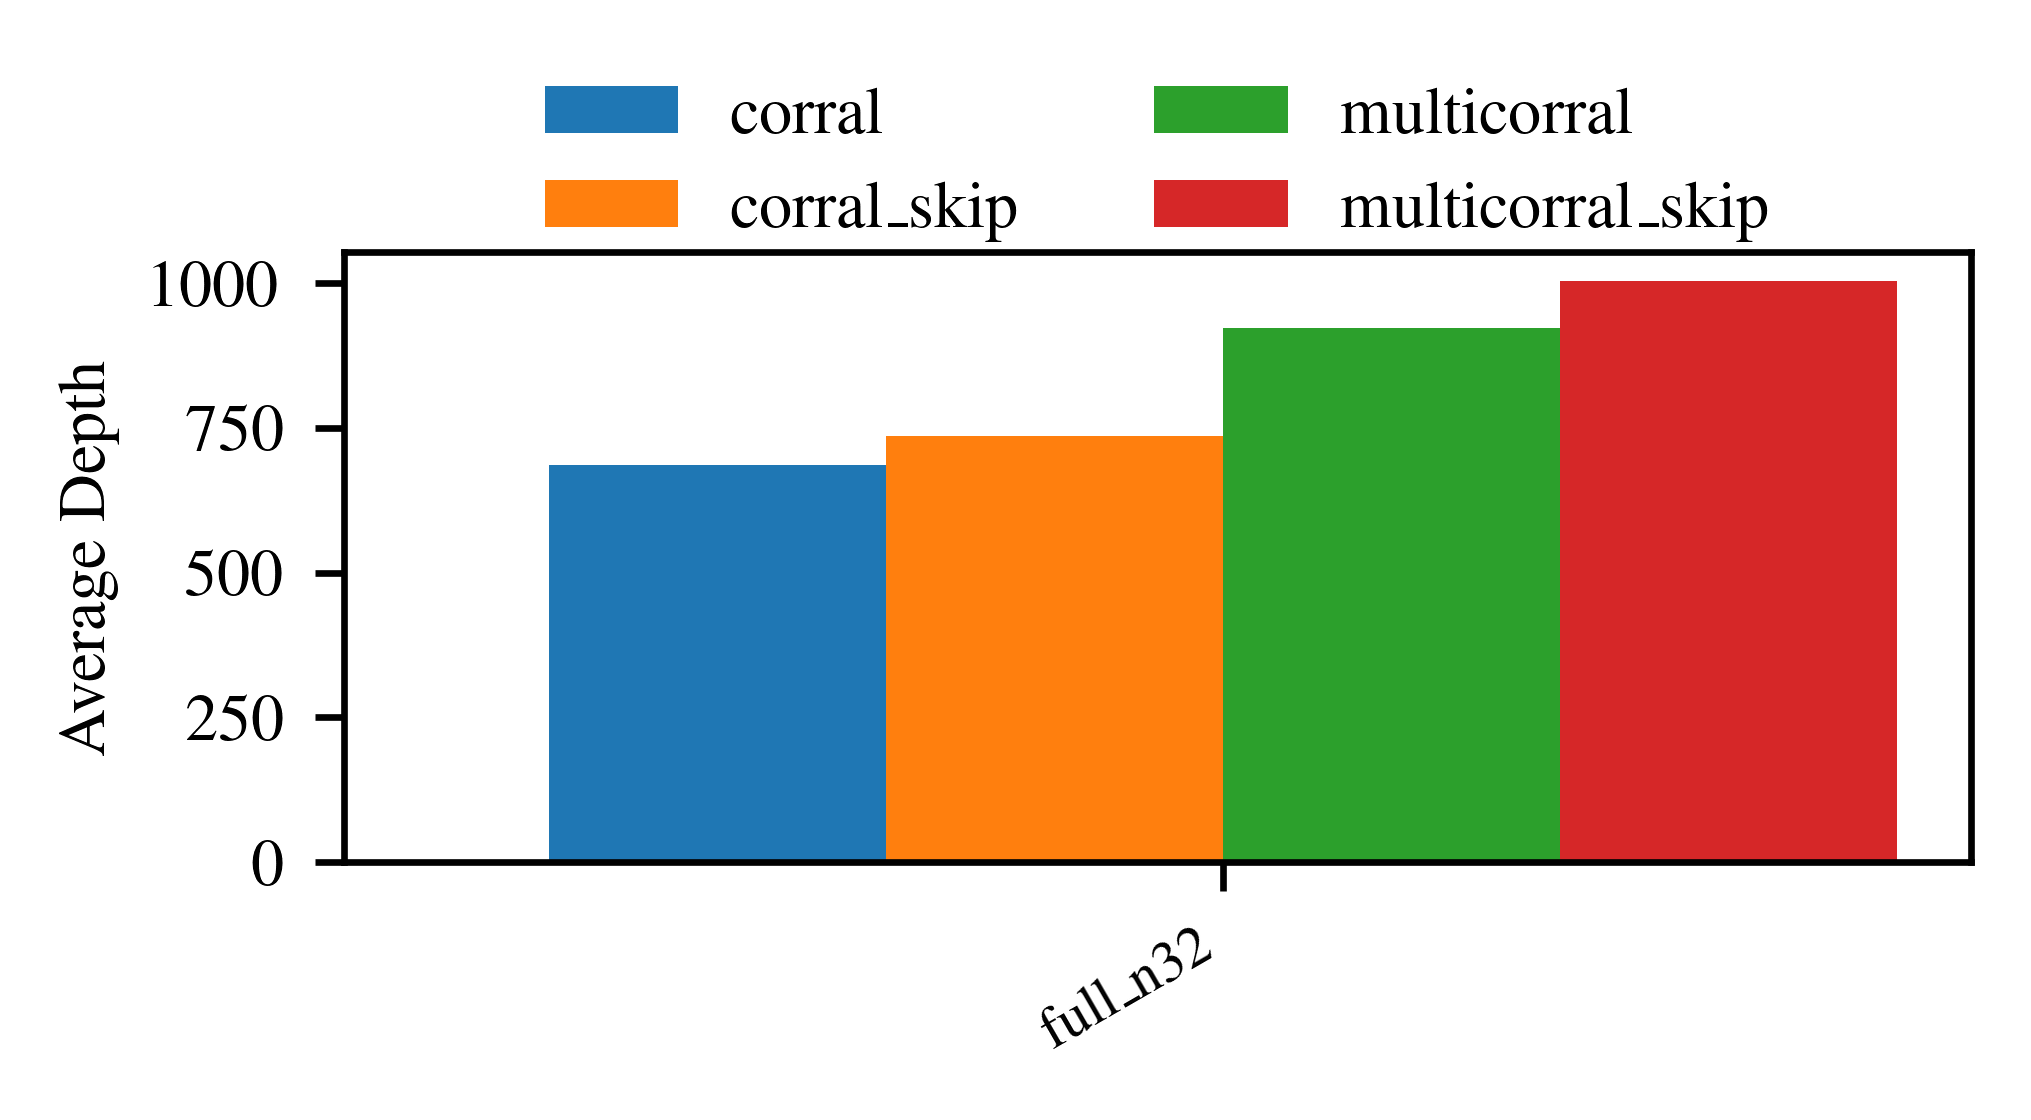

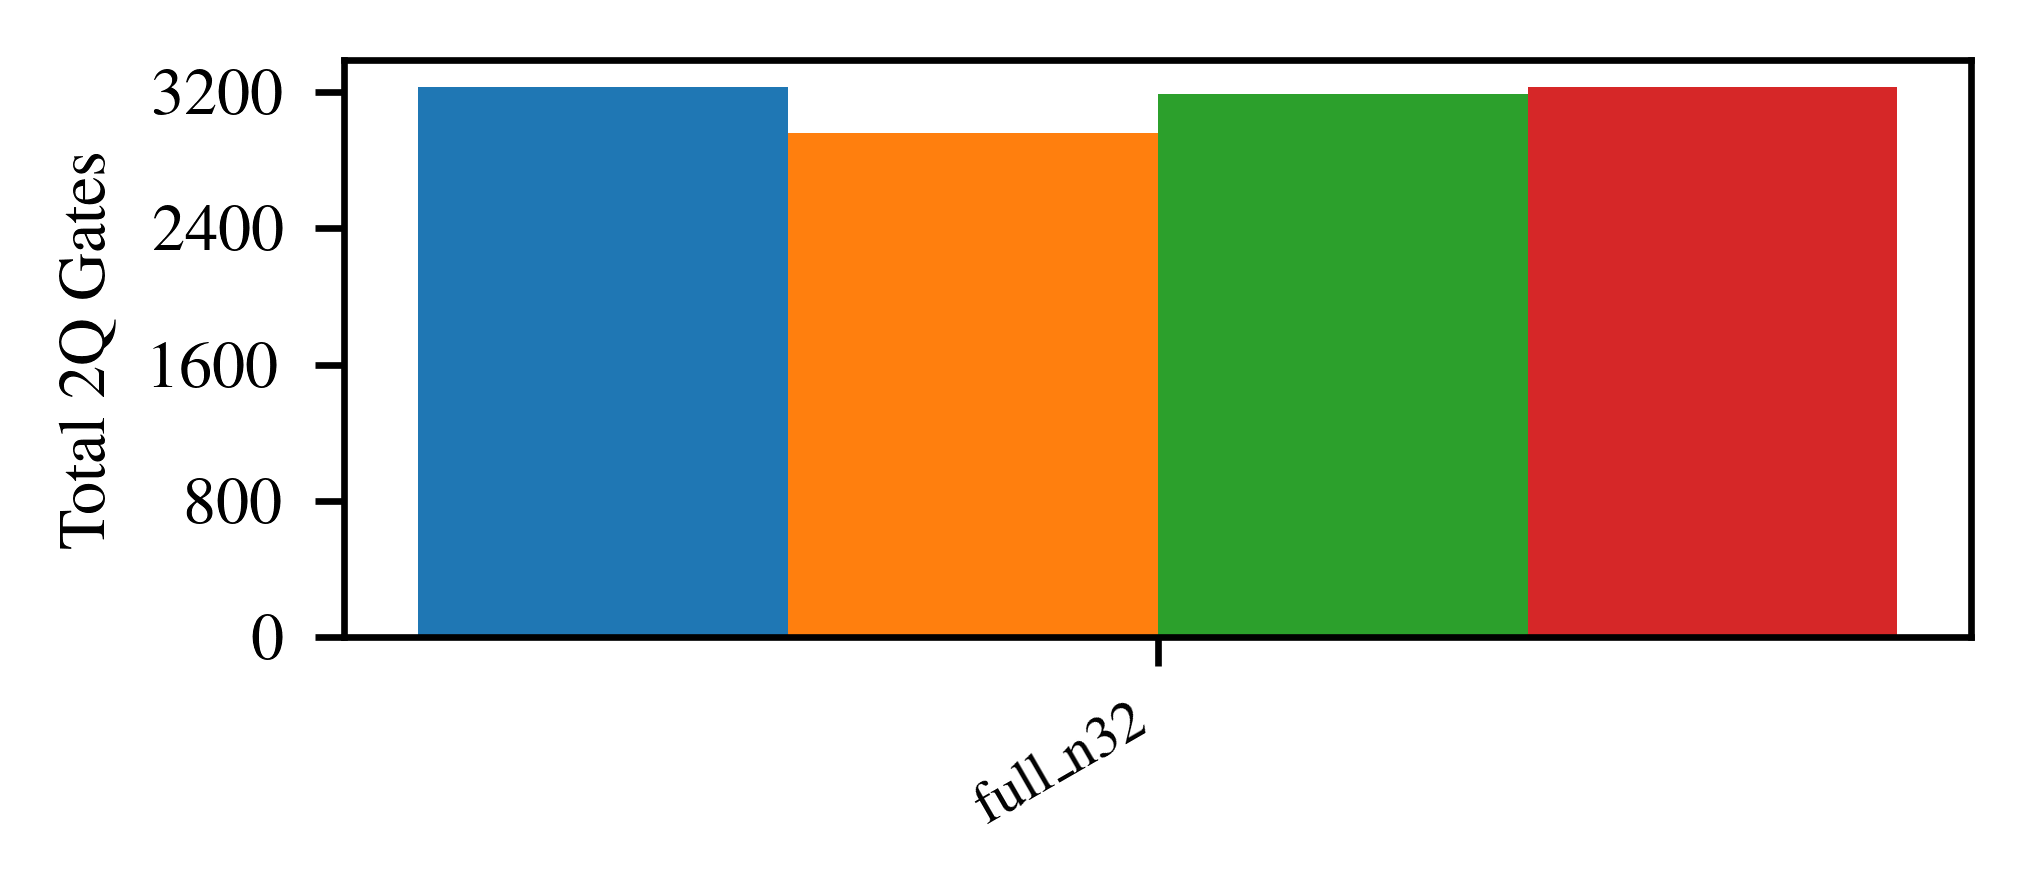

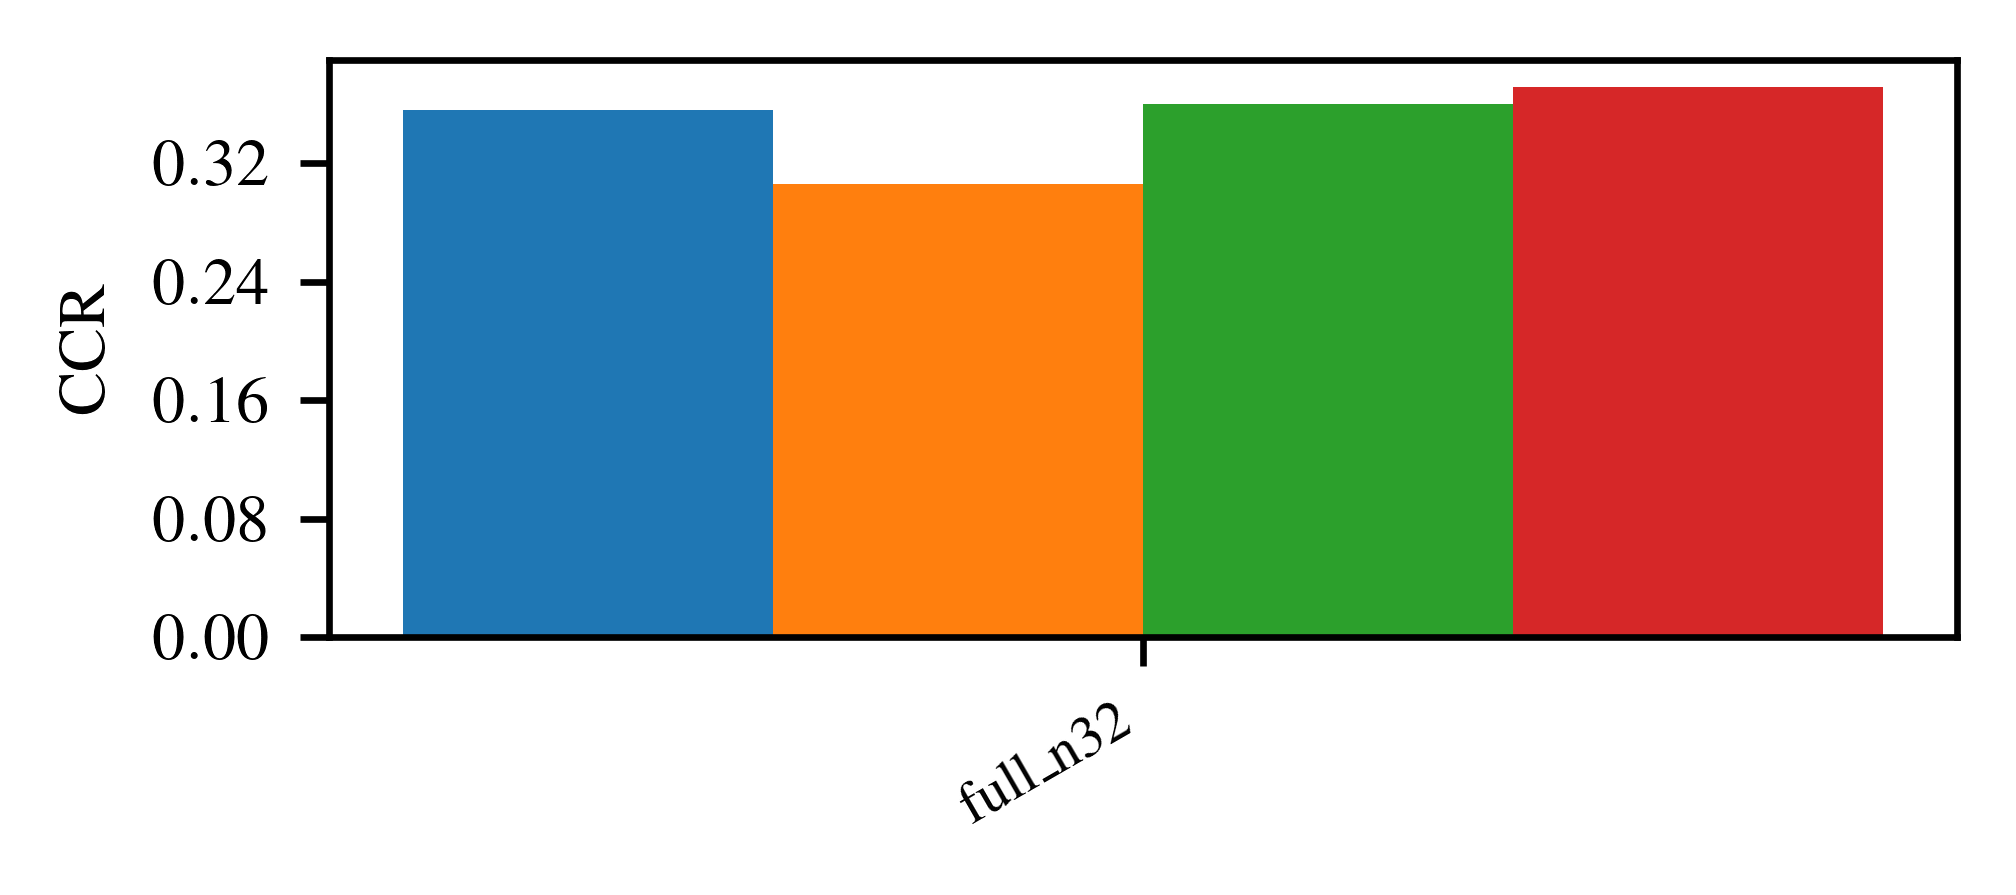

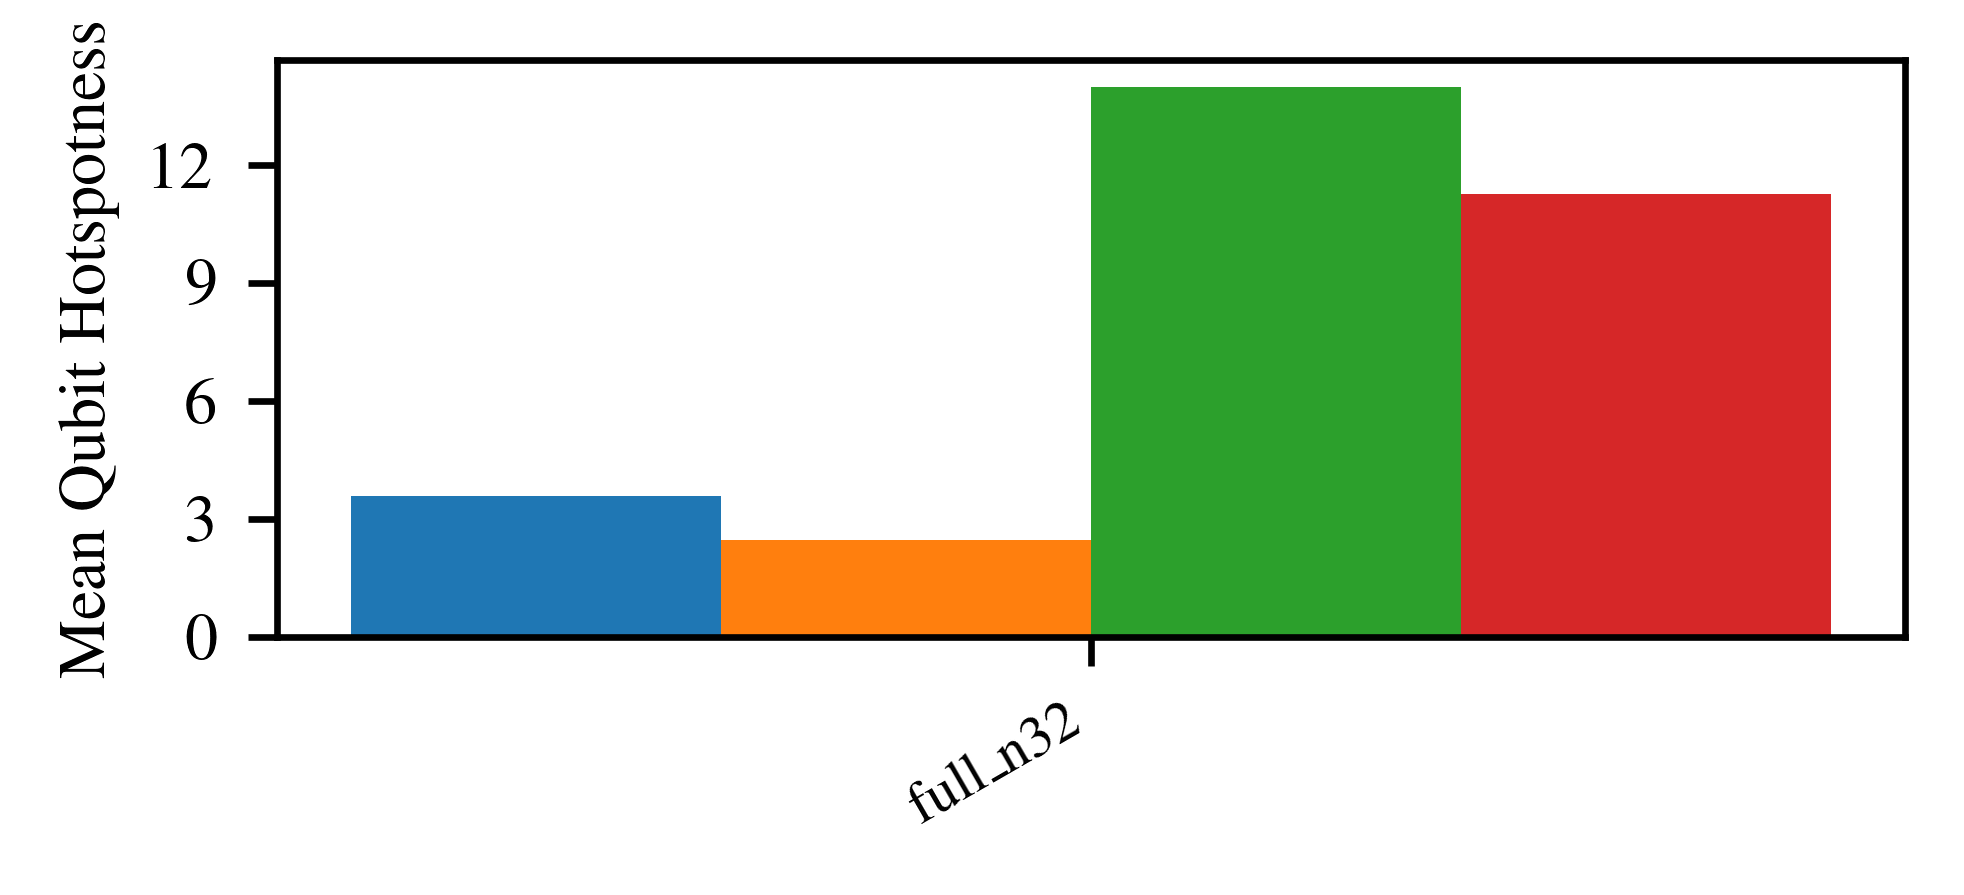

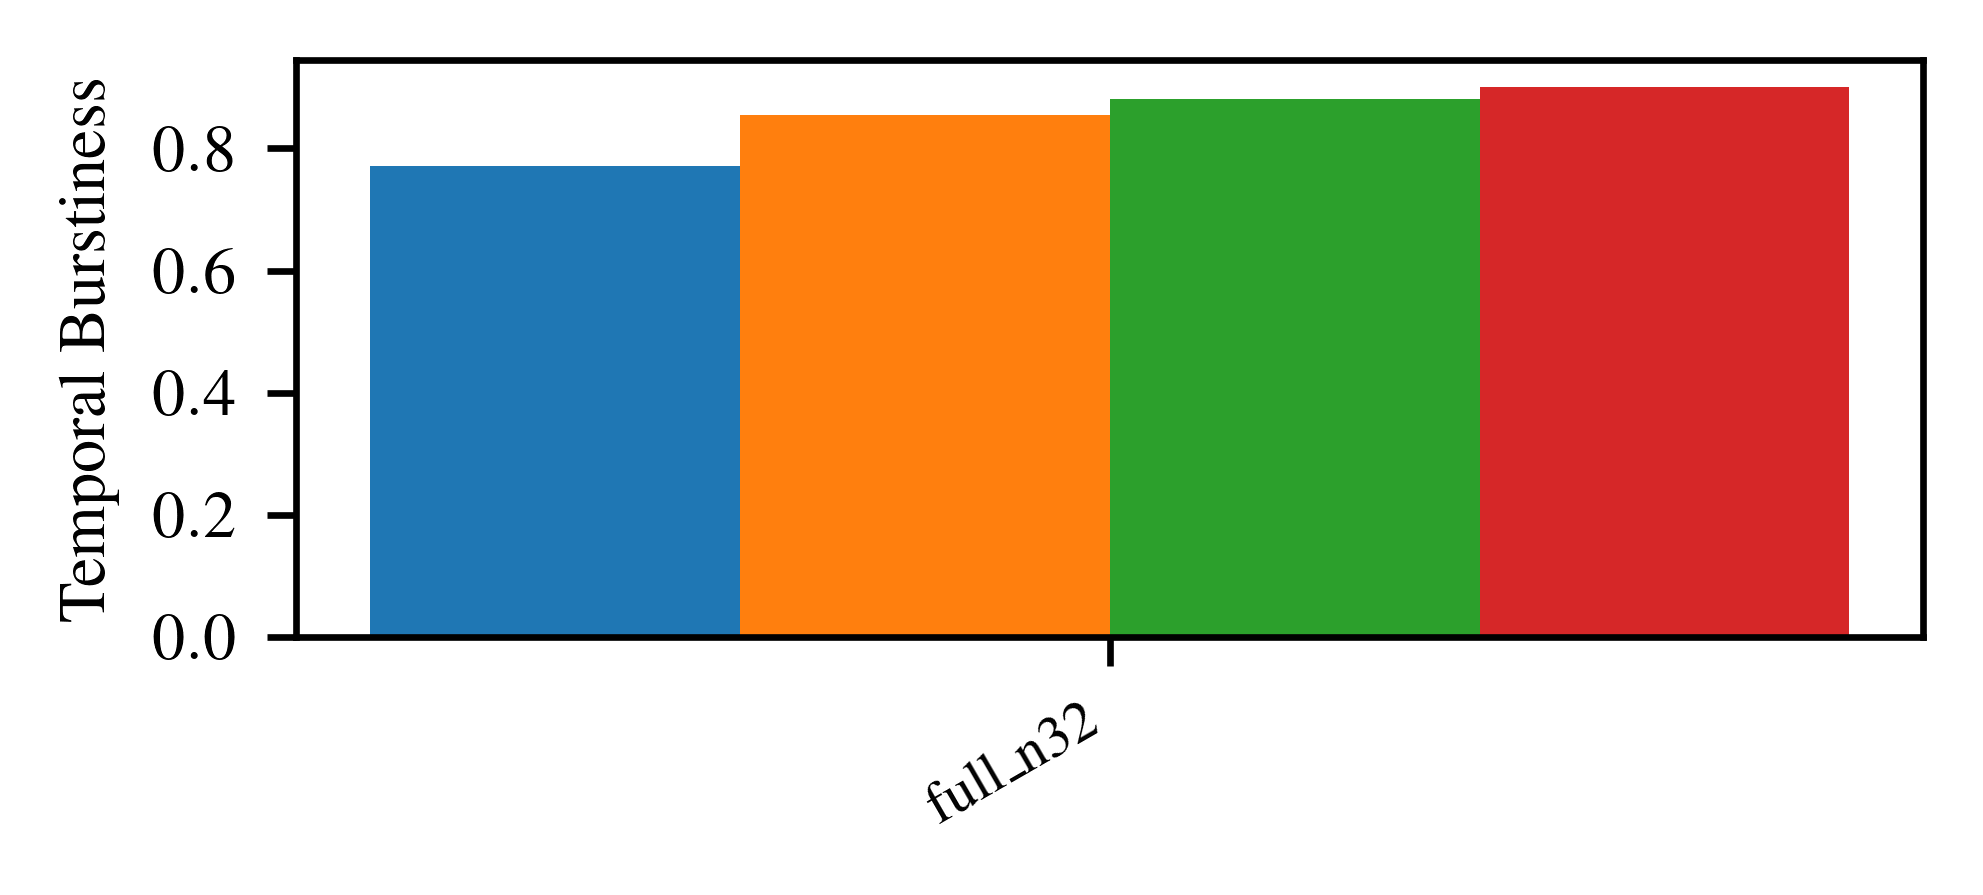

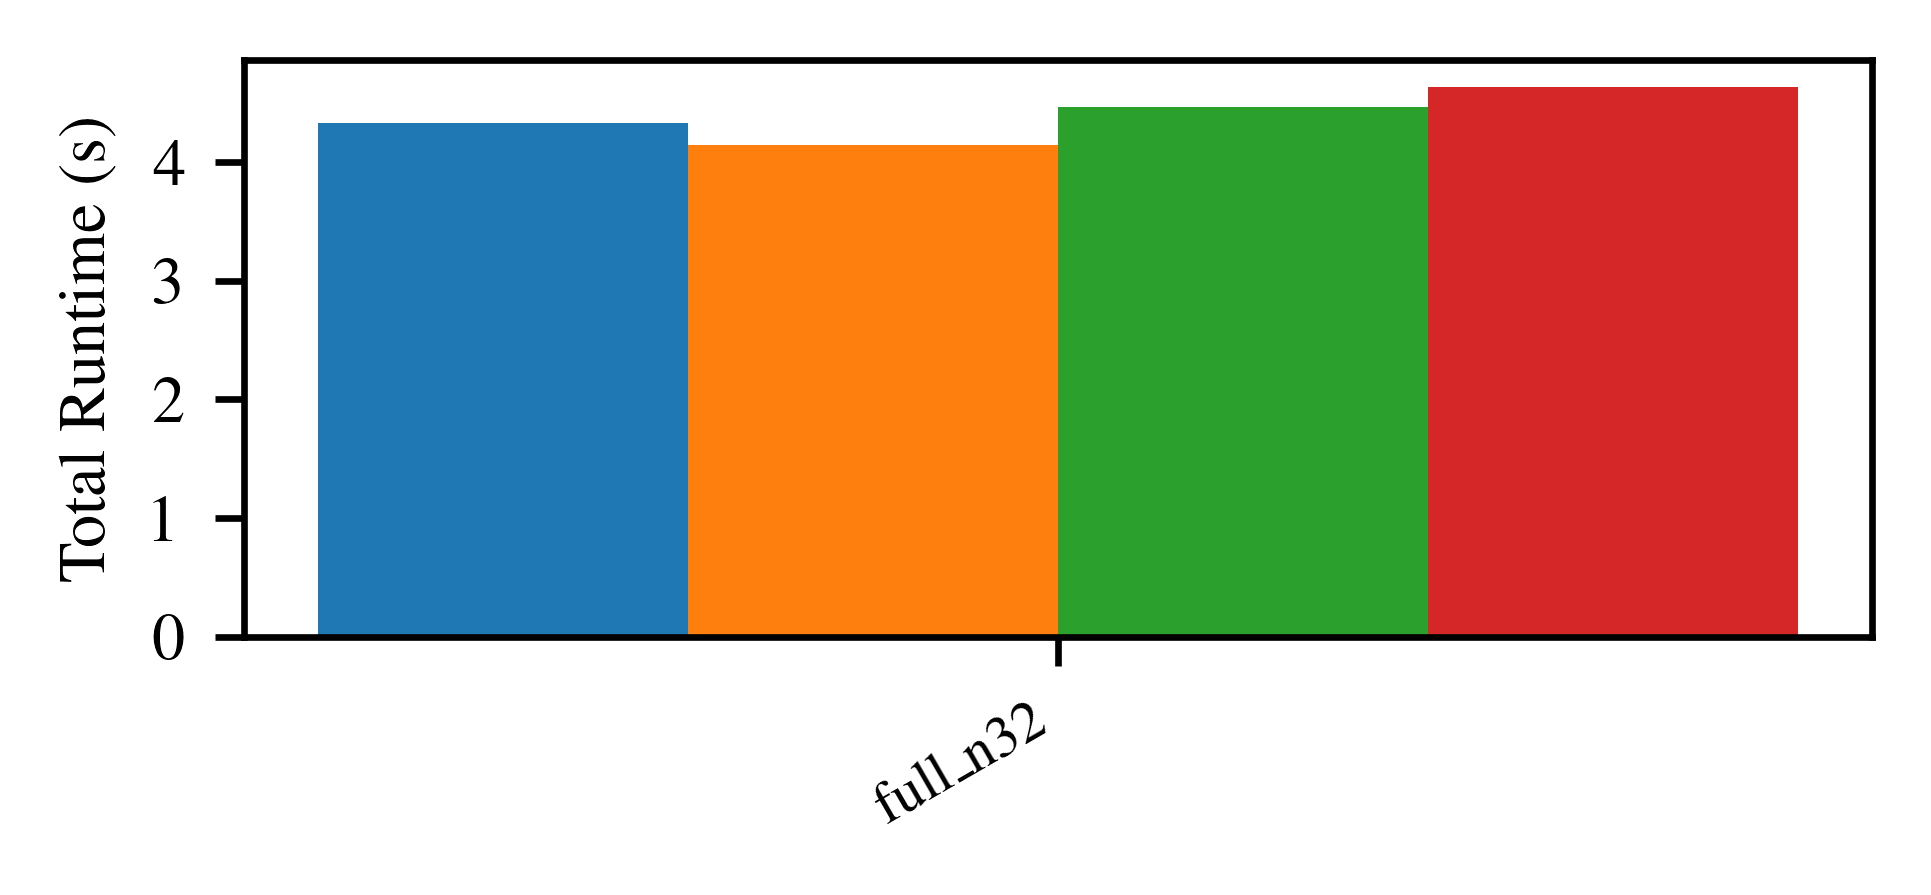

In [ ]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=0, legend_show=1)